In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload

import utils
import persim
import itertools

from sklearn import manifold, cluster, preprocessing
import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats,spatial

In [2]:
seed = 42
SCALE = 256
ndims = 3
minlife = 0.5
nrows, ncols = 2,3
fs = 14
PP = 10
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#e0e0e0', '#56b4e9', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#f0e442', '#000000']
cmap = ['Greys_r', 'Blues_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 

isrc += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col=0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
weight = np.load(ksrc + sample + '_border_weights.npy', allow_pickle=True)
transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
wall[tf.imread(nsrc + sample + '_EDT.tif') < 1] = False
wcoords = np.asarray(np.nonzero(~wall))
wallshape = wall.shape
wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

handles = [None for _ in range(len(Genes))]
for i in range(len(handles)):
    handles[i] = mlines.Line2D([], [], mfc=color[i], marker=marker[i], ls='None', mec='k', mew=1, ms=7)

In [3]:
normtype = 'both'
level = 'sup'
Bname = '{}level persistence. {} normalized.'.format(level.title(), normtype.title())

gsrc = '../{}level/'.format(level) + sample + os.sep

foo = glob(gsrc + transcriptomes[Genes[0]] + os.sep + '*')[0]
bar = os.path.split(foo)[1].split('_')
PP = int(bar[4][1:])
stepsize = int(bar[5][1:])
bw = int(bar[6][2:])
zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

jsonfiles = [ [ None for j in range(len(Cells)) ] for i in range(len(Genes)) ]
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]
ratios = utils.normalize_counts(transfocus, normtype)
print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
print(np.sum(ratios > 0, axis=1))
print(transfocus.sum(axis='columns'), '\n')

orig_diags = [None for i in range(len(jsonfiles))]
for i in range(len(orig_diags)):
    orig_diags[i] = utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True)

orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
diags, nzcumsum, nzmask = utils.reduce_num_of_diagrams(orig_diags, rescale, focus_dim, normtype, minlife=minlife, keepall=False)
lt_coll, maxbirth = utils.birthdeath_to_flattened_lifetime(diags, nzcumsum[-1])
print(list(map(len, diags)))

Max ratio by both:	0.24%
[968 950 956 464 960 968]
gene
GLYMA_17G195900    698882
GLYMA_05G216000     12919
GLYMA_17G185800     11462
GLYMA_05G203100      4116
GLYMA_15G210100     11688
GLYMA_05G092200    479091
dtype: int64 

Initial number of life-birth pairs	: 12427

No. of diagrams s.t. H_k had the most persistent component
H_0:	4668 [ 80.4% ]
H_1:	1140 [ 19.6% ]
H_2:	0 [ 0.0% ]

Will focus just on dimension k = 0

Non-zero diagrams:	2755
Compared to all diagrams:	5808	[47.43%]
[355, 372, 701, 104, 389, 834]


# Bring in persistence images to the party

In [4]:
sigma = 2
pers_w = 2
pixel_size = 8

pi_params = {'birth_range':(0,min([SCALE, maxbirth + 10])),
             'pers_range':(0,min([SCALE,maxlife[:,:,focus_dim].max()+10])),
             'pixel_size': pixel_size,
             'weight': 'persistence',
             'weight_params': {'n': pers_w},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
pi_extent = [ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]
img = np.asarray(pimgr.transform(lt_coll, skew=False))

foo = [isrc, level, normtype, int(sigma), pers_w, pixel_size, os.sep]
psrc = '{}{}level_-_by_{}_-_sigma_{}_-_pers+n_{}_-_pixel+size_{}{}'.format(*foo)

method = 'UMAP'
npy_files = sorted(glob(psrc + method.lower() + '*.npy'))
for i in range(len(npy_files)):
    print(i, os.path.split(npy_files[i])[1], sep='\t')

0	umap_-_n+neighbors_12_-_min+dist_0.0_-_metric_chebyshev_-_with+std_True.npy
1	umap_-_n+neighbors_12_-_min+dist_0.0_-_metric_euclidean_-_with+std_True.npy
2	umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_chebyshev_-_with+std_True.npy
3	umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_euclidean_-_with+std_True.npy
4	umap_-_n+neighbors_12_-_min+dist_0.3_-_metric_chebyshev_-_with+std_True.npy
5	umap_-_n+neighbors_12_-_min+dist_0.3_-_metric_euclidean_-_with+std_True.npy
6	umap_-_n+neighbors_24_-_min+dist_0.0_-_metric_chebyshev_-_with+std_True.npy
7	umap_-_n+neighbors_24_-_min+dist_0.0_-_metric_euclidean_-_with+std_True.npy
8	umap_-_n+neighbors_24_-_min+dist_0.1_-_metric_chebyshev_-_with+std_True.npy
9	umap_-_n+neighbors_24_-_min+dist_0.1_-_metric_euclidean_-_with+std_True.npy
10	umap_-_n+neighbors_24_-_min+dist_0.3_-_metric_chebyshev_-_with+std_True.npy
11	umap_-_n+neighbors_24_-_min+dist_0.3_-_metric_euclidean_-_with+std_True.npy
12	umap_-_n+neighbors_4_-_min+dist_0.0_-_metric_chebyshev_-_wi

In [5]:
npy = 3
print( os.path.split(npy_files[npy])[1] )
foo = os.path.splitext(os.path.split(npy_files[npy])[1])[0].split('_-_')[1:]
params_kws = [ bar.split('_')[0].replace('+', '_') for bar in foo ]
params_vals= [ bar.split('_')[1].replace('+', '_') for bar in foo ]
embed_params = dict(zip(params_kws,params_vals))
embedding = np.load(npy_files[npy], allow_pickle=True)
print(list(map(len, diags)))
np.sum(list(map(len, diags))) == len(embedding)

umap_-_n+neighbors_12_-_min+dist_0.1_-_metric_euclidean_-_with+std_True.npy
[968, 919, 933, 275, 942, 968]


True

In [6]:
dbscan_params = {'eps': 0.3, 'min_samples': 3, 'metric': embed_params['metric'], 'n_jobs':1}
dbscan = cluster.DBSCAN(**dbscan_params).fit(embedding)
labs = np.unique(dbscan.labels_)
labs

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [7]:
avg = np.zeros( (np.sum(labs != -1), pimgr.resolution[1], pimgr.resolution[0]))
for i in range(len(avg)):
    lmask = dbscan.labels_ == labs[i]
    avg[i] = np.mean(img[lmask], axis=0).T

/home/eah4d/documents/website/mcarto/figs/clustering_persistence_images_suplevel_both_normalized.jpg


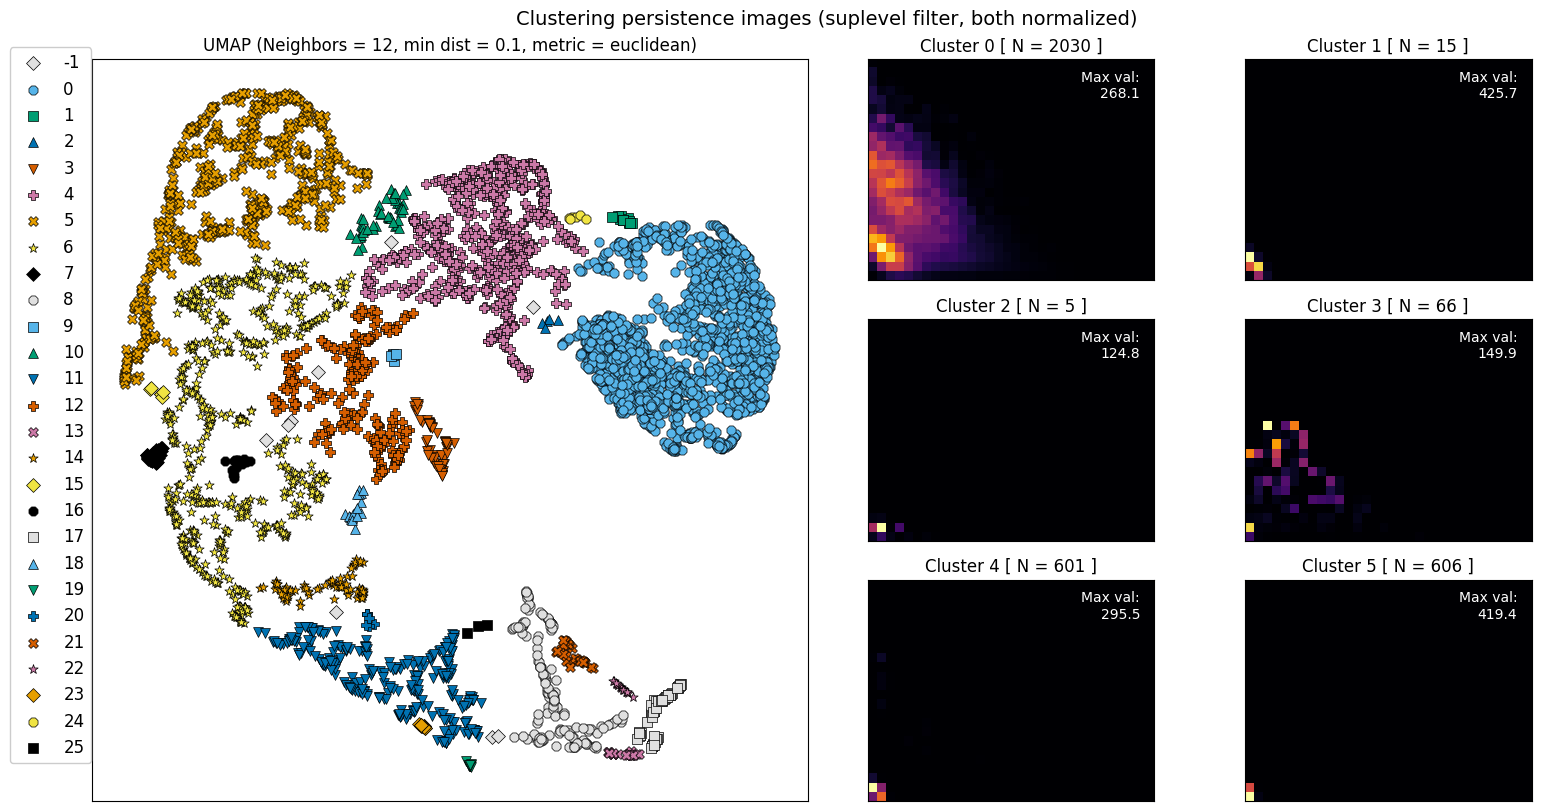

In [8]:
fig = plt.figure(figsize=(15, 8), layout="constrained")

gs = GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[:,:2])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[0,3])
ax4 = fig.add_subplot(gs[1,2])
ax5 = fig.add_subplot(gs[1,3])
ax6 = fig.add_subplot(gs[2,2])
ax7 = fig.add_subplot(gs[2,3])

for j in range(len(labs)):
    lmask = dbscan.labels_ == labs[j]
    fig.axes[0].scatter(*embedding[lmask].T, color=color[j%9], marker=marker[j%8], linewidth=0.5, edgecolor='k', label=labs[j], s=50)

fig.axes[0].set_title('UMAP (Neighbors = {}, min dist = {}, metric = {})'.format(*params_vals[:3]))
for i in range(1, len(fig.axes)):
    lmask = dbscan.labels_ == labs[i]
    fig.axes[i].imshow(avg[i], cmap='inferno', origin='lower', vmin=0,  extent=pi_extent)
    fig.axes[i].text((pi_extent[1] - pi_extent[0])*.95, (pi_extent[3] - pi_extent[2])*.95, 
               'Max val:\n{:.1f}'.format(np.max(avg[i])), color='w', ha='right', va='top')
    fig.axes[i].set_title('Cluster {} [ N = {} ]'.format(labs[i], np.sum(lmask) ) )

for ax in fig.axes:
    ax.set_aspect('equal')
    ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

fig.suptitle('Clustering persistence images ({}level filter, {} normalized)'.format(level, normtype), fontsize=fs)
fig.legend(loc='center left', bbox_to_anchor=(-0.05, 0.25, 0.5, 0.5), fontsize=12, framealpha=1);
filename = figdst + 'clustering_persistence_images_{}level_{}_normalized.jpg'.format(level,normtype)
print(filename)

plt.savefig(filename, dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

In [68]:
gidx = 0
s_ = np.s_[nzcumsum[gidx]:nzcumsum[gidx+1]]
pts = embedding[s_]

dbscan_params = {'eps': 0.5, 'min_samples': 7, 'metric': embed_params['metric'], 'n_jobs':1}
dbscan = cluster.DBSCAN(**dbscan_params).fit(pts)
labs = np.unique(dbscan.labels_)
nzlabs = labs[labs != -1]
labs

array([-1,  0])

In [71]:
ll = 0
clust = Cells[ nzmask[gidx][ dbscan.labels_ == ll ] ]
convexhull = spatial.ConvexHull(pts[dbscan.labels_ == ll])
hull = convexhull.points[convexhull.vertices]
hdgms = [diags[gidx][i] for i in np.nonzero(dbscan.labels_ == ll)[0] ]
hdgms = [hdgms[i] for i in convexhull.vertices]
mx = np.max(list(map(np.max, hdgms)))
hpis = img[s_][dbscan.labels_ == ll][convexhull.vertices]
clust = clust[convexhull.vertices]
hull.shape

(23, 2)

/home/eah4d/documents/website/mcarto/figs/GLYMA_17G195900_clustering_suplevel_both_normalized.jpg


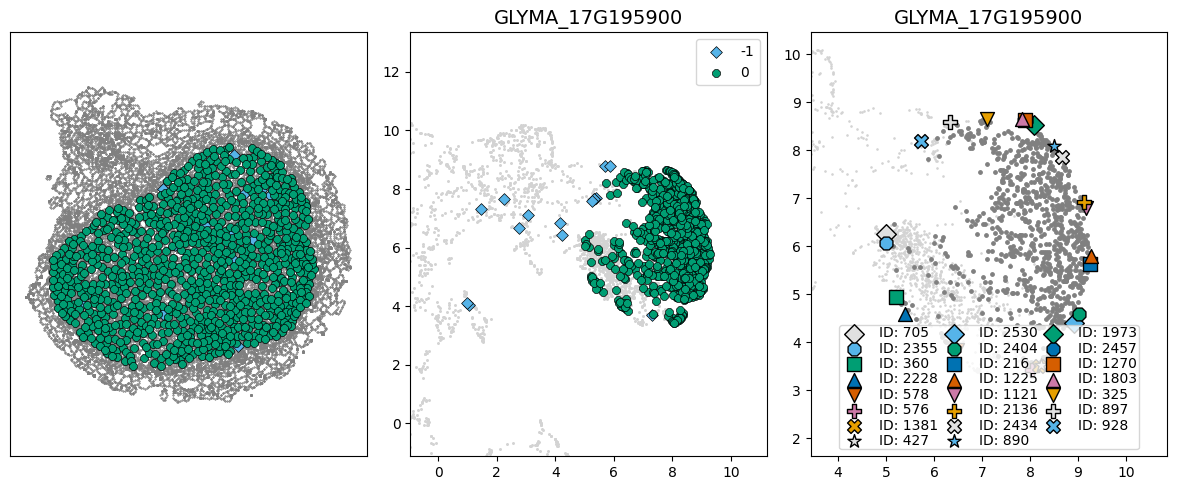

In [72]:
fig, ax = plt.subplots(1,3, figsize=(12,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

for j in range(len(labs)):
    i = 0
    cellloc = metacell.loc[Cells[ nzmask[gidx][ dbscan.labels_ == labs[j] ] ], ['ndimage_comX', 'ndimage_comY']]
    ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
    ax[i].scatter(cellloc['ndimage_comX'], cellloc['ndimage_comY'], c=color[j+1], marker=marker[j], 
                  edgecolor='black', linewidth=0.5, zorder=2)
    
    i = 1
    ax[i].scatter(embedding[:,0], embedding[:,1], c='lightgray', marker='.', alpha=1, zorder=1, s=3)
    ax[i].scatter(*(pts[dbscan.labels_ == labs[j]].T), color=color[j+1], marker=marker[j], zorder=4,
                  edgecolor='k', linewidth=0.5, label=labs[j])
    
i = 0
ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

i += 1
ax[i].legend()
ax[i].set_xlim(pts[:,0].min()-1, pts[:,0].max()+1)
ax[i].set_ylim(pts[:,1].min()-1, pts[:,1].max()+1)
ax[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)

i += 1
pp = pts[dbscan.labels_ == ll]
ax[i].scatter(embedding[:,0], embedding[:,1], c='lightgray', marker='.', s=3, alpha=1, zorder=1)
ax[i].scatter(*(pp.T), color='gray', marker='o', zorder=4, s=6)
for j in range(len(clust)):
    cidx = clust[j]
    ax[i].scatter(hull[j,0], hull[j,1], color=color[j%7], marker=marker[j%8], zorder=4, s=100,
                 edgecolor='k', linewidth=1, label = 'ID: {}'.format(metacell.loc[cidx, 'orig_cellID']) )

ax[i].legend(ncols=3, borderpad=0.1, labelspacing=0.1, columnspacing=0.1, loc='lower center')
ax[i].set_xlim(pp[:,0].min()-1, pp[:,0].max()+1)
ax[i].set_ylim(pp[:,1].min()-1, pp[:,1].max()+1)
ax[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)

for i in range(len(ax)):
    ax[i].set_aspect('equal','datalim')

fig.tight_layout();
filename = figdst + '{}_clustering_{}level_{}_normalized.jpg'.format(transcriptomes[Genes[gidx]], level,normtype)
print(filename)

plt.savefig(filename, dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

In [73]:
KDE = [None for _ in range(len(clust))]
hcells = [None for _ in range(len(clust))]
hcoords = [None for _ in range(len(clust))]
hextent = [None for _ in range(len(clust))]
hzhist = [None for _ in range(len(clust))]

for i in range(len(clust)):
    cidx = clust[i]
    cell, extent = utils.get_cell_img(cidx, metacell, wall, label, pxbar=False)
    axes, grid, gmask, cgrid, cgridmask = utils.cell_grid_preparation(cell, extent, zmax, stepsize)
    cmask = label [translocs[Genes[gidx]]['Y'], translocs[Genes[gidx]]['X'] ] == cidx
    coords = translocs[Genes[gidx]].iloc[ cmask].values.T
    zhist, _ = np.histogram(coords[2], bins=zbins, density=True)
    zlevel = np.argmax(zhist)
    w = weight[tcumsum[Genes[gidx]]:tcumsum[Genes[gidx]+1]][cmask]
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T, w).evaluate(grid)
    kde = kde[gmask]/( np.sum(kde[gmask]) * (stepsize**len(coords)) )
    kde[ cgridmask ] = 0
    kde = kde/( np.sum(kde) * (stepsize**len(coords)) )
    
    KDE[i] = kde.reshape( list(map(len, axes))[::-1], order='F')
    hcells[i] = cell
    hextent[i] = extent
    hcoords[i] = coords
    hzhist[i] = zhist
    
rr = ratios[gidx][dbscan.labels_ == ll][convexhull.vertices]
hkdes = [ KDE[i].copy()*rr[i] for i in range(len(rr)) ]
kx = np.max(list(map(np.max, hkdes)))
hzlevel = np.array(list(map(np.argmax, hzhist)))
hzmax = np.max(list(map(np.max, hzhist)))

pxs = 75
pxbar = np.s_[-15:-5, 5:5 + pxs]
for cell in hcells:
    cell[pxbar] = 0

/home/eah4d/documents/website/mcarto/figs/GLYMA_17G195900_hull_details_suplevel_both_normalized_01.jpg


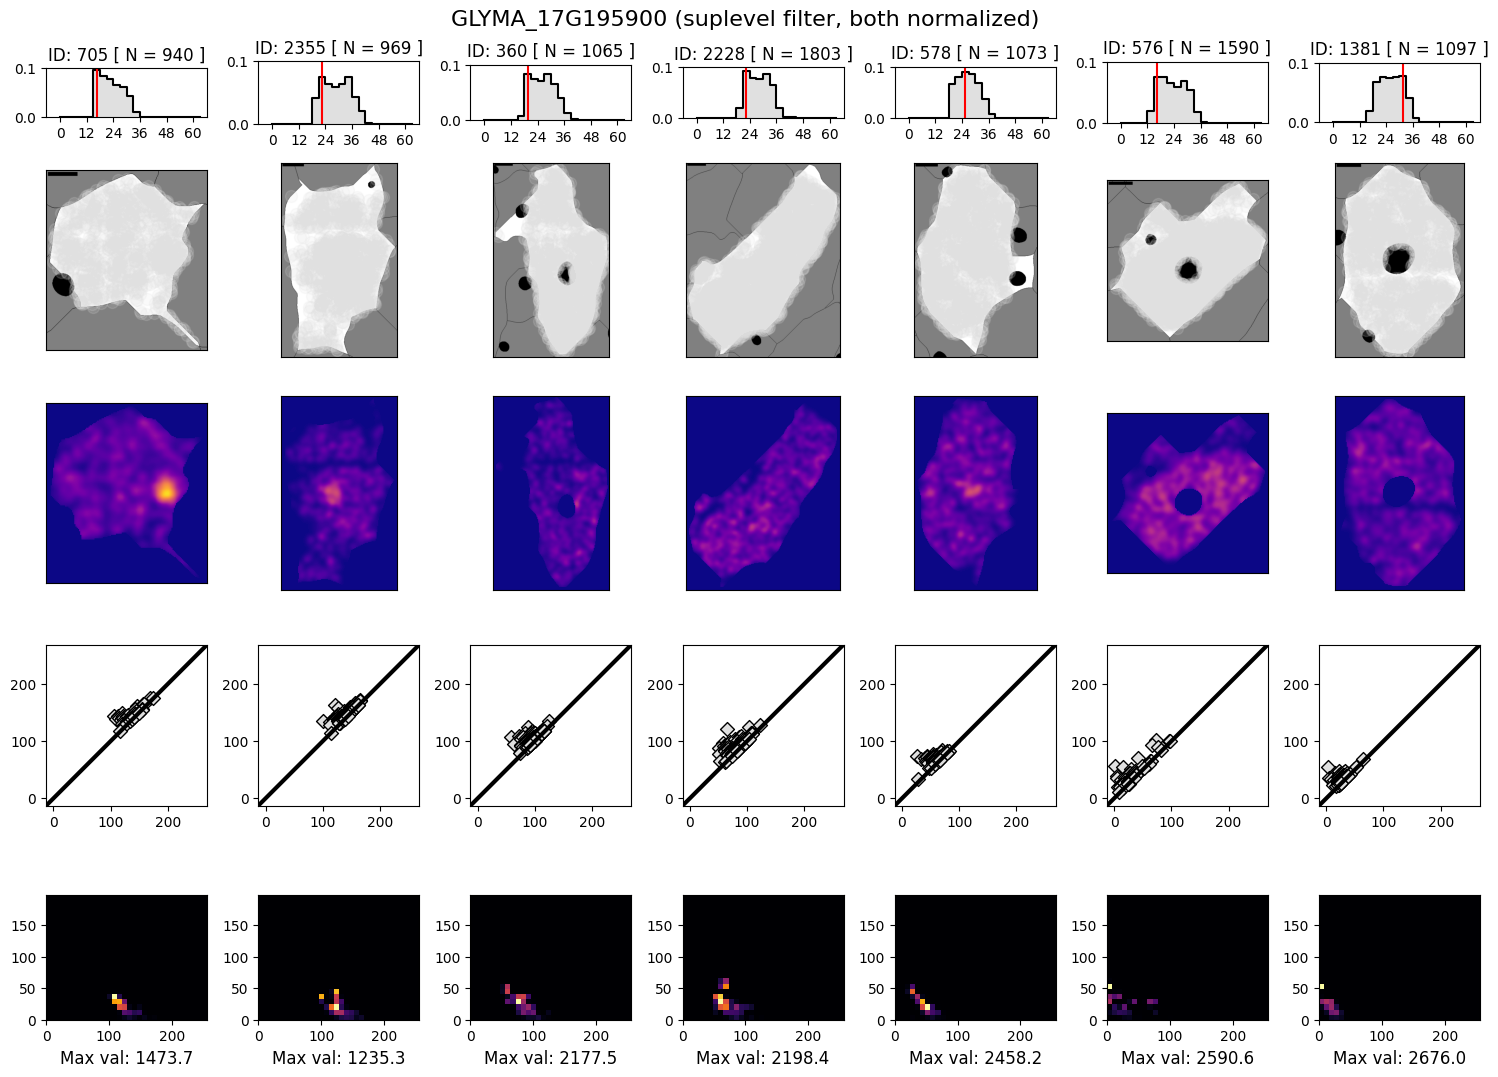

In [74]:
skipby = 0
w_r = 3

fig, ax = plt.subplots(5, 7, figsize=(15,11), sharex=False, sharey=False, height_ratios=[1, w_r, w_r, w_r, w_r])
ax = np.atleast_2d(ax); i = 0

for k in range(ax.shape[1]):
    i = k + skipby
    cidx = clust[i]
    
    j = 0
    sc = w_r*np.max(hzhist[i])/zbins[-2]
    ax[j,k].bar(sc*zbins[:-1]-stepsize*sc*0.5, hzhist[i], stepsize*sc, color=color[gidx])
    ax[j,k].plot(sc*zbins[:-1],  hzhist[i], c='k', ds='steps')
    ax[j,k].set_xticks(sc*zbins[:-1:4], zbins[:-1:4])
    ax[j,k].set_yticks([0, hzmax], np.round( [0, np.round(hzmax, 1) ], 3))
    ax[j,k].axvline(sc*(stepsize*hzlevel[i]-stepsize*0.5), c='r')
    ax[j,k].set_title('ID: {} [ N = {} ]'.format(metacell.loc[cidx, 'orig_cellID'], len(hcoords[i][0])), fontsize=12)
    
    j += 1
    ax[j,k].imshow(hcells[i], cmap='binary_r', origin='lower', extent=hextent[i], vmin=0, vmax=2);
    ax[j,k].scatter(hcoords[i][0], hcoords[i][1], color=color[gidx], marker='o', alpha=0.15, s=75)
    ax[j,k].set_facecolor('#808080')
    ax[j,k].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

    j += 1
    ax[j,k].imshow(hkdes[i][hzlevel[i],:,:], origin='lower', cmap='plasma', vmin=0, vmax=kx, zorder=1)
    ax[j,k].set_facecolor('#0d0887')
    ax[j,k].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
    j += 1
    ax[j,k].scatter(hdgms[i][:,0], hdgms[i][:,1], marker=marker[gidx], c=color[gidx], s=50, linewidth=1, edgecolor='k', zorder=2)
    ax[j,k].scatter([0, pi_extent[1]] , [0, pi_extent[1]] , alpha=0, s=300)
    ax[j,k].axline(xy1=(0,0), slope=1, c='k', zorder=3, lw=3)

    j += 1
    ax[j,k].imshow(hpis[i].T, cmap='inferno', origin='lower', vmin=0,  extent=pi_extent)
    ax[j,k].set_xlabel('Max val: {:.1f}'.format(np.max(hpis[i])), fontsize=12)

for a in ax.ravel():
    a.set_aspect('equal','box')

foo = [transcriptomes[Genes[gidx]], level, normtype]
fig.suptitle('{} ({}level filter, {} normalized)'.format(*foo), fontsize=16)

fig.tight_layout();

filename = figdst + '{}_hull_details_{}level_{}_normalized_{:02d}.jpg'.format(transcriptomes[Genes[gidx]], level,normtype, skipby+1)
print(filename)

plt.savefig(filename, dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

In [75]:
sqdist = spatial.distance.squareform( spatial.distance.pdist(hull), checks=False )
argmax = np.argmax(sqdist)
ix, jx = np.unravel_index(argmax, sqdist.shape)
sqdist = spatial.distance.cdist( convexhull.points[convexhull.vertices[[ix,jx]]], pp)
relvals = sqdist/np.sum( sqdist, axis=0)

KeyError: 253

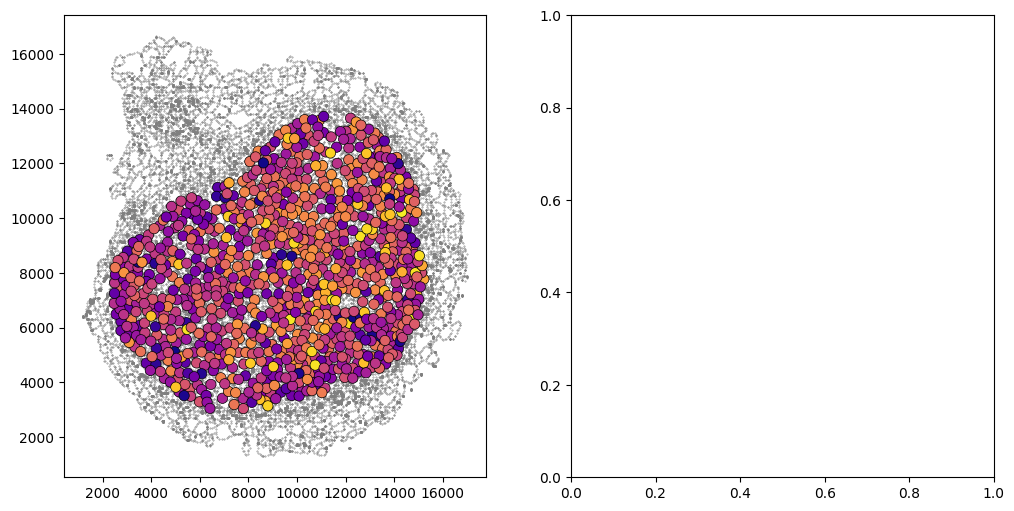

In [76]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

i = 0

ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(cellloc['ndimage_comX'], cellloc['ndimage_comY'], c=relvals[0], marker='o', cmap='plasma',
              edgecolor='black', linewidth=0.5, zorder=2, s=55)
for j in [ix,jx]:
    cidx = clust[j]
    ax[i].scatter(cellloc.loc[convexhull.vertices[j] ,'ndimage_comX'], cellloc.loc[convexhull.vertices[j] ,'ndimage_comY'],
                  color=color[j%7], marker=marker[j%8], zorder=5, s=300,
                 edgecolor='k', linewidth=1)

i += 1
pp = pts[dbscan.labels_ == ll]
ax[i].scatter(*(pp.T), c=relvals[0], marker='o', s=10, alpha=1, zorder=1, cmap='plasma')
for j in [ix,jx]:
    cidx = clust[j]
    ax[i].scatter(hull[j,0], hull[j,1], color=color[j%7], marker=marker[j%8], zorder=4, s=100,
                 edgecolor='k', linewidth=1, label = 'ID: {}'.format(metacell.loc[cidx, 'orig_cellID']) )

ax[i].legend(ncols=3, borderpad=0.1, labelspacing=0.1, columnspacing=0.1, loc='lower center')
ax[i].set_xlim(pp[:,0].min()-1, pp[:,0].max()+1)
ax[i].set_ylim(pp[:,1].min()-1, pp[:,1].max()+1)
ax[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)

for i in range(len(ax)):
    ax[i].set_aspect('equal','datalim')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();
filename = figdst + '{}_relative_{}level_{}_normalized.jpg'.format(transcriptomes[Genes[gidx]], level,normtype)
print(filename)

#plt.savefig(filename, dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

/home/eah4d/documents/website/mcarto/figs/GLYMA_05G092200_relative_suplevel_both_normalized.jpg


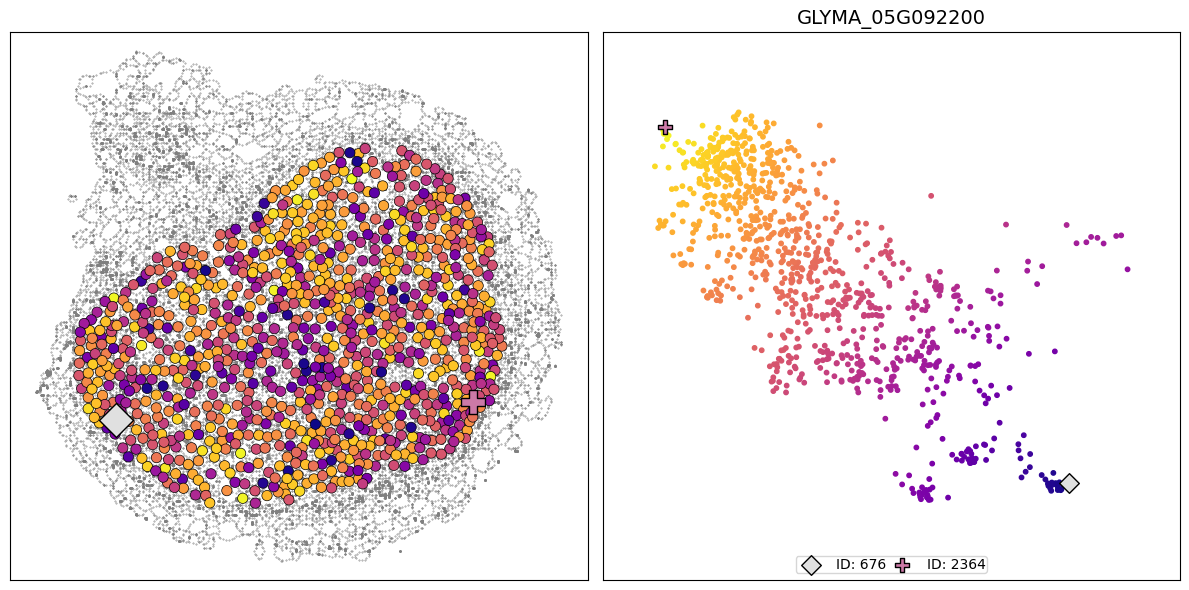

In [67]:
fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

i = 0

ax[i].scatter(wc[1], wc[0], c='#808080', marker='.', s=0.5, zorder=1)
ax[i].scatter(cellloc['ndimage_comX'], cellloc['ndimage_comY'], c=relvals[0], marker='o', cmap='plasma',
              edgecolor='black', linewidth=0.5, zorder=2, s=55)
for j in [ix,jx]:
    cidx = clust[j]
    ax[i].scatter(cellloc.loc[convexhull.vertices[j] ,'ndimage_comX'], cellloc.loc[convexhull.vertices[j] ,'ndimage_comY'],
                  color=color[j%7], marker=marker[j%8], zorder=5, s=300,
                 edgecolor='k', linewidth=1)

i += 1
pp = pts[dbscan.labels_ == ll]
ax[i].scatter(*(pp.T), c=relvals[0], marker='o', s=10, alpha=1, zorder=1, cmap='plasma')
for j in [ix,jx]:
    cidx = clust[j]
    ax[i].scatter(hull[j,0], hull[j,1], color=color[j%7], marker=marker[j%8], zorder=4, s=100,
                 edgecolor='k', linewidth=1, label = 'ID: {}'.format(metacell.loc[cidx, 'orig_cellID']) )

ax[i].legend(ncols=3, borderpad=0.1, labelspacing=0.1, columnspacing=0.1, loc='lower center')
ax[i].set_xlim(pp[:,0].min()-1, pp[:,0].max()+1)
ax[i].set_ylim(pp[:,1].min()-1, pp[:,1].max()+1)
ax[i].set_title(transcriptomes[Genes[gidx]], fontsize=fs)

for i in range(len(ax)):
    ax[i].set_aspect('equal','datalim')
    ax[i].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout();
filename = figdst + '{}_relative_{}level_{}_normalized.jpg'.format(transcriptomes[Genes[gidx]], level,normtype)
print(filename)

#plt.savefig(filename, dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

In [41]:
clust[ix]

675

In [28]:
convexhull.points[convexhull.vertices[[ix,jx]]]

array([[5.5154805, 6.034911 ],
       [5.4641843, 5.5478525],
       [5.1424017, 6.194861 ],
       ...,
       [7.587706 , 5.626705 ],
       [5.5677767, 5.610476 ],
       [7.352997 , 4.7601876]], dtype=float32)

# Explore